In [75]:
import sys
import warnings
warnings.simplefilter("ignore")
sys.path.append("..")
print(sys.executable)

/home/sherry/anaconda3/envs/graph/bin/python


In [76]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from MCMC_train import get_triplets, posterior
from utils.distance_requester import distance_requester

In [92]:
DATA_PATH = '/home/sherry/Dropbox/PhD/Data/TBI/TBI_Connectomes_wSubcort'
OUT_PATH = '/home/sherry/Dropbox/PhD/Results/tbi_mcmc_exp01/mcmc_output'
ROI_PATH = '/home/sherry/Dropbox/PhD/Data/TBI/atlas/Schaefer2018_116Parcels_7Networks_LookupTable.csv'
TEST_PATH = '/home/sherry/Dropbox/PhD/Results/tbi_mcmc_exp01/cv_list/test_list_fold0.txt'
TRAIN_PATH = '/home/sherry/Dropbox/PhD/Results/tbi_mcmc_exp01/cv_list/train_list_fold0.txt'
LAST_ITER = 29
N_NODE = 116

In [78]:
with open(os.path.join(OUT_PATH, 'iter'+str(LAST_ITER)+'.pkl'), 'rb') as f:
    param_list, p_list, accepted, rejected, df_dist = pickle.load(f)

[0, 2, 8, 12, 14, 17, 19, 22, 23, 24, 27, 28, 29]
selected_iter: [29, 19, 0]


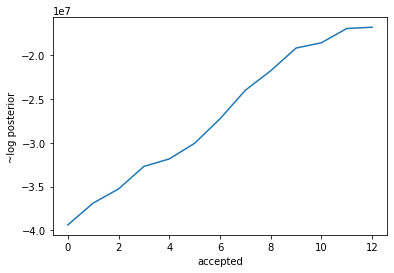

In [79]:
print(accepted)
FIRST_ITER = accepted[0]
MID_ITER = accepted[int(len(accepted)/2)]
iter_list = [LAST_ITER, MID_ITER, FIRST_ITER]
print('selected_iter:', iter_list)
plt.plot(np.array(p_list)[accepted])
plt.xlabel('accepted')
plt.ylabel('~log posterior')
plt.show()

In [80]:
df_roi = pd.read_csv(ROI_PATH, names = ['Index', 'Label'])
df_roi = df_roi.drop(columns = ['Index'])
df_roi['Network'] = [x.split('_')[2] if x.startswith('7Networks') else 'Sub' for x in df_roi['Label']]
df_roi['Hemisphere'] = [x.split('_')[1][0] if x.startswith('7Networks') else x.split('-')[-1][0] for x in df_roi['Label']]
df_roi

,Label,Network,Hemisphere
0,7Networks_LH_Vis_1,Vis,L
1,7Networks_LH_Vis_2,Vis,L
2,7Networks_LH_Vis_3,Vis,L
3,7Networks_LH_Vis_4,Vis,L
4,7Networks_LH_Vis_5,Vis,L
...,...,...,...
111,Pallidum-Right,Sub,R
112,Hippocampus-Right,Sub,R
113,Amygdala-Right,Sub,R
114,Accumbens-area-Right,Sub,R


In [81]:
subj_list = [x for x in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, x))]
subj_list.remove('p021')

conn_dict = {}
for subj in subj_list:
    filelist = [x for x in os.listdir(os.path.join(DATA_PATH, subj))
                            if str(N_NODE) in x.split('_') and x.startswith('DTI')]
    filelist.sort()
    conn_dict[subj] = {}
    for filename in filelist:
        filepath = os.path.join(DATA_PATH, subj, filename)
        seq = filename.split('.')[0].split('_')[-1]
        conn_dict[subj][seq] = np.loadtxt(filepath)

### Training Result

In [114]:
df_dist_all = df_dist[['subjects', 'dx_groups', 'times']]

accuracy_measures = ['graphedit_accuracy_all', 'graphedit_accuracy_R', 'graphedit_accuracy_L']
columns_network = list(np.unique(df_roi['Network']))
for network in columns_network:
    accuracy_measures.append('graphedit_accuracy_'+network)
accuracy_measures_all = []

dist_measures = ['graphedit']
dist_measures_all = ['euclidean', 'pearson']

for i in iter_list:
    with open(os.path.join(OUT_PATH, 'iter'+str(i)+'.pkl'), 'rb') as f:
        _, _, _, _, df_dist_new = pickle.load(f)
        df_dist_new = df_dist_new[['subjects', 'graphedit', 'graphedit_match']]
        df_dist_new['graphedit'] = df_dist_new['graphedit'] / df_dist_new['graphedit'].max()
        
        graphedit_accuracy = [(x == np.arange(len(x))).mean() for x in df_dist_new['graphedit_match']]        
        df_dist_new['graphedit_accuracy_all_'+str(i)] = graphedit_accuracy
        for network in columns_network:
            roi_mask = df_roi['Network'].to_numpy() == network
            graphedit_accuracy = [(x == np.arange(len(x)))[roi_mask].mean() for x in df_dist_new['graphedit_match']]
            df_dist_new['graphedit_accuracy_'+network+'_'+str(i)] = graphedit_accuracy
        for hemisphere in ['R', 'L']:
            roi_mask = df_roi['Hemisphere'].to_numpy() == hemisphere
            graphedit_accuracy = [(x == np.arange(len(x)))[roi_mask].mean() for x in df_dist_new['graphedit_match']]
            df_dist_new['graphedit_accuracy_'+hemisphere+'_'+str(i)] = graphedit_accuracy
        df_dist_new = df_dist_new.rename(columns={'graphedit': 'graphedit_'+str(i), 'graphedit_match': 'graphedit_match_'+str(i)})

        df_dist_all = df_dist_all.merge(df_dist_new, on='subjects')
        
        dist_measures_all = dist_measures_all + [x+'_'+str(i) for x in dist_measures]
        accuracy_measures_all = accuracy_measures_all + [x+'_'+str(i) for x in accuracy_measures]

In [115]:
train_list = np.loadtxt(TRAIN_PATH, dtype=str)
train_label = np.array([x[0] for x in train_list])
train_triplets = get_triplets(train_list, train_label)

In [116]:
dist_dic = {}
for tri in train_triplets:
    (p, c1, c2) = tri
    conn_p, conn_c1, conn_c2 = conn_dict[p]['s1'], conn_dict[c1]['s1'], conn_dict[c2]['s1']
    dist_dic[(p, c1)] = [distance_requester(conn_p, conn_c1).euclidean(),
                         distance_requester(conn_p, conn_c1).pearson()[0]]
    dist_dic[(p, c2)] = [distance_requester(conn_p, conn_c2).euclidean(),
                         distance_requester(conn_p, conn_c2).pearson()[0]]
    if dist_dic.get((c1, c2)) is None:
        dist_dic[(c1, c2)] = [distance_requester(conn_c1, conn_c2).euclidean(),
                              distance_requester(conn_c1, conn_c2).pearson()[0]]
subjects = list(dist_dic.keys())
euclidean = np.array([x[0] for x in dist_dic.values()])
pearson = np.array([x[1] for x in dist_dic.values()])
df_dist_all = df_dist_all.merge(pd.DataFrame({'subjects': subjects,
                                              'euclidean': euclidean/euclidean.max(),
                                              'pearson': pearson/pearson.max()}),
                                on='subjects')
df_dist_all

,subjects,dx_groups,times,graphedit_29,graphedit_match_29,graphedit_accuracy_all_29,graphedit_accuracy_Cont_29,graphedit_accuracy_Default_29,graphedit_accuracy_DorsAttn_29,graphedit_accuracy_Limbic_29,...,graphedit_accuracy_DorsAttn_0,graphedit_accuracy_Limbic_0,graphedit_accuracy_SalVentAttn_0,graphedit_accuracy_SomMot_0,graphedit_accuracy_Sub_0,graphedit_accuracy_Vis_0,graphedit_accuracy_R_0,graphedit_accuracy_L_0,euclidean,pearson
0,"(p040, c001)",pc,s1s1,0.805687,"[0, 7, 2, 3, 4, 5, 1, 6, 8, 9, 10, 11, 12, 13,...",0.793103,0.692308,0.791667,0.866667,1.0,...,0.800000,0.6,0.833333,0.857143,0.7500,0.882353,0.827586,0.775862,0.783426,0.619529
1,"(p040, c008)",pc,s1s1,0.811829,"[0, 1, 2, 3, 48, 5, 6, 7, 4, 9, 10, 11, 12, 13...",0.706897,0.538462,0.625000,0.800000,0.8,...,0.733333,0.8,0.666667,0.714286,0.8125,0.705882,0.706897,0.672414,0.796495,0.718293
2,"(c001, c008)",cc,s1s1,0.817461,"[2, 1, 0, 3, 4, 5, 6, 7, 8, 9, 10, 18, 12, 16,...",0.793103,0.846154,0.791667,0.666667,1.0,...,0.466667,0.8,0.750000,0.714286,0.8750,0.882353,0.775862,0.689655,0.752646,0.577926
3,"(p040, c037)",pc,s1s1,0.803079,"[0, 1, 104, 3, 4, 5, 6, 7, 8, 9, 10, 13, 12, 2...",0.793103,0.692308,0.791667,0.866667,1.0,...,0.933333,1.0,0.916667,0.785714,0.9375,1.000000,0.827586,0.896552,0.759890,0.624073
4,"(c001, c037)",cc,s1s1,0.846572,"[6, 104, 4, 1, 2, 5, 0, 7, 8, 9, 10, 36, 12, 1...",0.646552,0.538462,0.708333,0.666667,1.0,...,0.600000,1.0,0.583333,0.571429,0.7500,0.647059,0.706897,0.517241,0.836533,0.694318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,"(p032, c029)",pc,s1s1,0.773079,"[0, 1, 103, 6, 3, 5, 38, 7, 8, 9, 10, 11, 12, ...",0.818966,0.923077,0.791667,0.800000,0.8,...,0.733333,0.8,0.916667,0.642857,0.8125,0.823529,0.879310,0.758621,0.737514,0.622881
1330,"(p032, c038)",pc,s1s1,0.739049,"[0, 3, 2, 10, 4, 5, 6, 7, 8, 9, 23, 11, 12, 13...",0.905172,1.000000,0.875000,1.000000,0.6,...,0.866667,0.8,1.000000,0.928571,1.0000,0.941176,0.965517,0.931034,0.641051,0.450455
1331,"(p032, c018)",pc,s1s1,0.815924,"[33, 1, 2, 105, 4, 5, 6, 3, 35, 9, 10, 18, 12,...",0.732759,0.692308,0.750000,0.733333,0.6,...,0.800000,0.6,0.750000,0.714286,0.8125,0.764706,0.810345,0.724138,0.754183,0.591175
1332,"(p032, c019)",pc,s1s1,0.825361,"[0, 1, 2, 3, 105, 5, 6, 7, 8, 16, 12, 9, 11, 2...",0.663793,0.769231,0.583333,0.666667,0.6,...,0.800000,0.6,0.500000,0.714286,0.7500,0.941176,0.862069,0.655172,0.765337,0.637995


In [117]:
tests = ['mean(pc)', 'mean(cc)',
         'std(pc)', 'std(cc)',
         'Normality_stats(pc)', 'Normality_stats(cc)', 'Normality_p(pc)', 'Normality_p(cc)',
         'levene_stats(pc/cc)', 'levene_p(pc/cc)',
         't-test_stats(pc/cc)', 't-test_p(pc/cc)', 't-test_es(pc/cc)',
         'mannwhitneyu_stats(pc/cc)', 'mannwhitneyu_p(pc/cc)', 'mannwhitneyu_es(pc/cc)']
df_test_all = pd.DataFrame({'tests': tests})

for dist_measure in dist_measures_all+accuracy_measures_all:
    g0 = df_dist_all[(df_dist_all['dx_groups'] == 'pc') & (df_dist_all['times'] == 's1s1')][dist_measure]
    g1 = df_dist_all[(df_dist_all['dx_groups'] == 'cc') & (df_dist_all['times'] == 's1s1')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.std(g0), np.std(g1)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    test_score_list = test_score_list + [statistics0, statistics1, p0, p1]
    
    statistics0, p0 = stats.levene(g0, g1)
    test_score_list = test_score_list + [statistics0, p0]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    #if p0 < 0.01:
    #    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    #else:
    #    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=True)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    test_score_list = test_score_list + [statistics0, p0, es0]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    test_score_list = test_score_list + [statistics0, p0, es0]
    
    df_test_all[dist_measure] = test_score_list
df_test_all = df_test_all.set_index('tests')

In [118]:
tests_filter = tests.copy()
dist_measures_filter = dist_measures_all.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test_all.loc[tests_filter][dist_measures_filter]

,euclidean,pearson,graphedit_29,graphedit_19,graphedit_0
tests,,,,,
mean(pc),7.380339e-01,6.252167e-01,8.557491e-01,8.796158e-01,8.728085e-01
mean(cc),6.872500e-01,5.543009e-01,8.164364e-01,8.458111e-01,8.423649e-01
std(pc),7.452165e-02,1.061615e-01,4.738071e-02,4.131531e-02,4.134334e-02
std(cc),5.872566e-02,7.947345e-02,4.269105e-02,3.705272e-02,3.779182e-02
Normality_p(pc),2.576882e-11,3.657135e-13,8.610598e-01,3.890096e-01,7.401456e-01
Normality_p(cc),9.145901e-03,1.512926e-03,2.743959e-01,2.978230e-01,1.916612e-01
levene_p(pc/cc),7.173409e-05,3.786207e-07,4.242745e-02,2.048714e-02,5.780478e-02
t-test_p(pc/cc),2.362316e-37,4.025743e-38,5.285789e-45,3.464738e-44,5.520718e-36
t-test_es(pc/cc),7.244856e-01,7.176809e-01,8.545236e-01,8.436987e-01,7.554873e-01


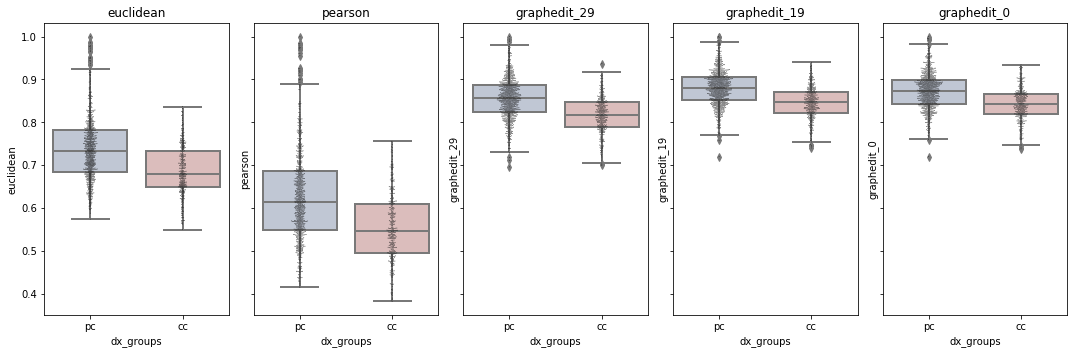

In [125]:
# Box plot
df_dist_sub = df_dist_all[(df_dist_all['times'] == 's1s1')]
fig, ax = plt.subplots(1, len(dist_measures_filter), sharey=True, figsize=(15, 5))

for i in range(len(dist_measures_filter)):
    params = dict(data=df_dist_sub, x='dx_groups', y=dist_measures_filter[i], order=['pc', 'cc'], ax=ax[i])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    sns.swarmplot(color=".1", size=0.8, **params)
    ax[i].set_title(dist_measures_filter[i])
    
plt.tight_layout(pad=1.0)
plt.show()

In [126]:
tests_filter = tests.copy()
accuracy_measures_filter = accuracy_measures_all.copy()
accuracy_measures_filter = [x for x in accuracy_measures_filter if '_all_' in x or '_L_' in x or '_R_' in x]
accuracy_measures_filter.sort(reverse=True)
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test_all.loc[tests_filter][accuracy_measures_filter]

,graphedit_accuracy_all_29,graphedit_accuracy_all_19,graphedit_accuracy_all_0,graphedit_accuracy_R_29,graphedit_accuracy_R_19,graphedit_accuracy_R_0,graphedit_accuracy_L_29,graphedit_accuracy_L_19,graphedit_accuracy_L_0
tests,,,,,,,,,
mean(pc),7.302226e-01,7.603950e-01,7.504180e-01,7.461913e-01,7.770697e-01,7.585835e-01,7.142539e-01,7.437203e-01,7.422525e-01
mean(cc),7.836547e-01,8.100900e-01,8.034440e-01,7.897061e-01,8.174367e-01,8.033379e-01,7.776032e-01,8.027433e-01,8.035502e-01
std(pc),9.695331e-02,9.545957e-02,9.486761e-02,1.121785e-01,1.079612e-01,1.085081e-01,1.249885e-01,1.230746e-01,1.210033e-01
std(cc),8.499795e-02,7.901646e-02,8.006721e-02,9.021690e-02,8.431032e-02,8.629155e-02,1.160469e-01,1.083370e-01,1.065615e-01
Normality_p(pc),3.440904e-05,7.205905e-07,2.125935e-06,1.125791e-05,2.945565e-07,5.445080e-06,1.228676e-04,1.232969e-06,6.172349e-07
Normality_p(cc),6.481166e-03,3.669953e-04,5.667252e-03,2.338148e-02,5.066884e-03,1.536883e-02,1.245543e-04,1.797905e-05,5.002284e-06
levene_p(pc/cc),1.660243e-02,3.214000e-04,2.277203e-03,6.802924e-06,8.514931e-07,1.217870e-06,1.764902e-01,1.881722e-02,2.338360e-03
t-test_p(pc/cc),9.150499e-23,5.438884e-22,2.183946e-24,1.475716e-13,4.053457e-13,2.913172e-15,2.311500e-18,9.481364e-18,1.578191e-19
t-test_es(pc/cc),-5.715875e-01,-5.474489e-01,-5.851236e-01,-4.105809e-01,-3.982709e-01,-4.376310e-01,-5.178182e-01,-4.968807e-01,-5.248032e-01


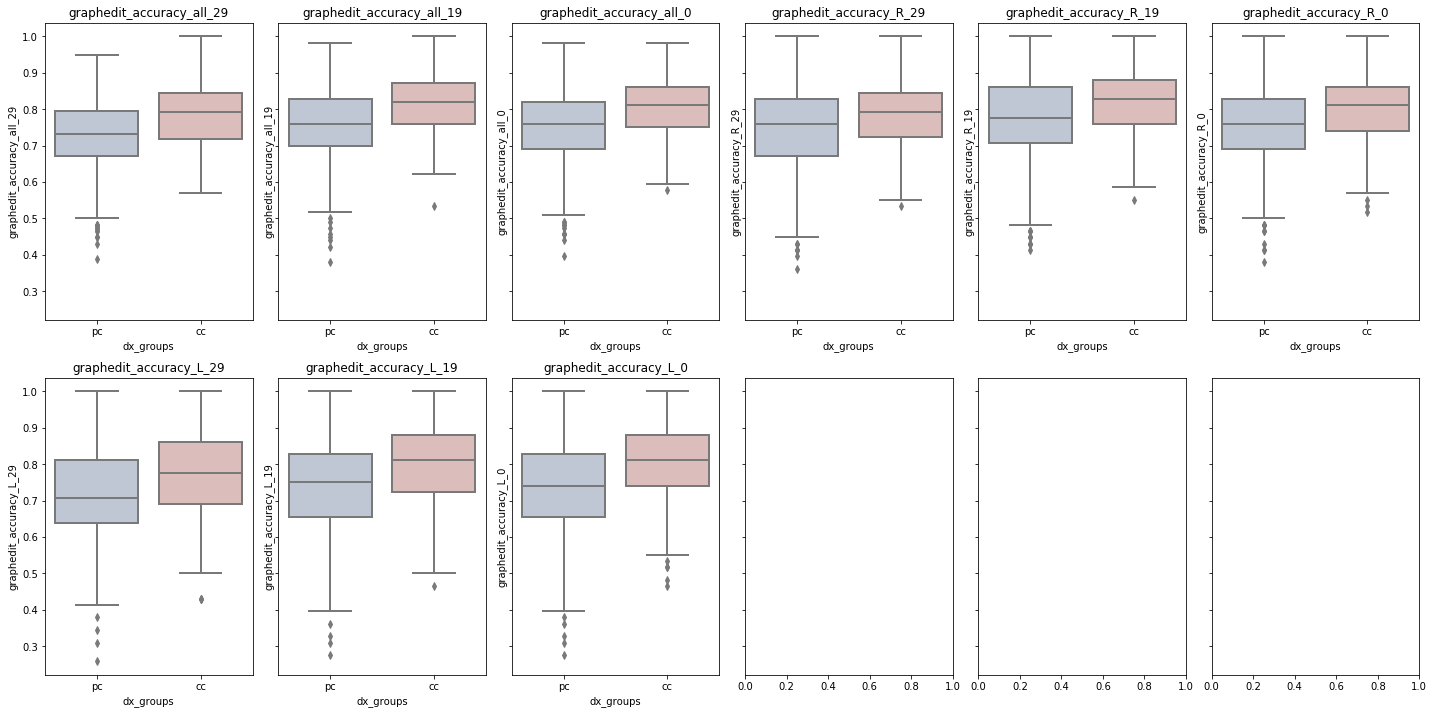

In [127]:
# Box plot
df_dist_sub = df_dist_all[(df_dist_all['times'] == 's1s1')]
accuracy_measures_filter = accuracy_measures_all.copy()
accuracy_measures_filter = [x for x in accuracy_measures_filter if '_all_' in x or '_L_' in x or '_R_' in x]
accuracy_measures_filter.sort(reverse=True)

fig, ax = plt.subplots(int(np.ceil(len(accuracy_measures_filter)/6)), 6, sharey=True, figsize=(20, 10))

for i in range(len(accuracy_measures_filter)):
    params = dict(data=df_dist_sub, x='dx_groups', y=accuracy_measures_filter[i], order=['pc', 'cc'], ax=ax[int(i/6), i%6])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    ax[int(i/6), i%6].set_title(accuracy_measures_filter[i])

plt.tight_layout(pad=1.0)
plt.show()

In [128]:
tests_filter = tests.copy()
accuracy_measures_filter = accuracy_measures_all.copy()
accuracy_measures_filter = [x for x in accuracy_measures_filter if '_Vis_' in x or '_Sub_' in x or '_SomMot_' in x or '_SalVentAttn_' in x]
accuracy_measures_filter.sort(reverse=True)
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test_all.loc[tests_filter][accuracy_measures_filter]

,graphedit_accuracy_Vis_29,graphedit_accuracy_Vis_19,graphedit_accuracy_Vis_0,graphedit_accuracy_Sub_29,graphedit_accuracy_Sub_19,graphedit_accuracy_Sub_0,graphedit_accuracy_SomMot_29,graphedit_accuracy_SomMot_19,graphedit_accuracy_SomMot_0,graphedit_accuracy_SalVentAttn_29,graphedit_accuracy_SalVentAttn_19,graphedit_accuracy_SalVentAttn_0
tests,,,,,,,,,,,,
mean(pc),7.666075e-01,8.680908e-01,8.725913e-01,7.427936e-01,7.862338e-01,7.930361e-01,6.377771e-01,6.568658e-01,6.390856e-01,7.617636e-01,7.574533e-01,7.247665e-01
mean(cc),8.130977e-01,9.052449e-01,9.087221e-01,8.257389e-01,8.660714e-01,8.803879e-01,6.949331e-01,7.042576e-01,6.866643e-01,8.148604e-01,8.097291e-01,7.881773e-01
std(pc),1.566001e-01,1.250589e-01,1.264524e-01,1.534592e-01,1.458283e-01,1.378589e-01,1.697531e-01,1.712204e-01,1.707398e-01,1.500944e-01,1.475569e-01,1.612331e-01
std(cc),1.476295e-01,1.064872e-01,1.034795e-01,1.235205e-01,1.094778e-01,1.038061e-01,1.609808e-01,1.529262e-01,1.539618e-01,1.333775e-01,1.411275e-01,1.446210e-01
Normality_p(pc),8.001577e-16,7.645406e-26,1.790771e-27,3.171898e-13,9.438004e-17,7.263444e-17,3.568855e-10,6.333319e-11,2.647638e-10,1.084264e-16,8.032311e-17,9.213630e-17
Normality_p(cc),5.253102e-13,1.749138e-20,1.007330e-20,6.624189e-12,2.574583e-14,8.704864e-16,4.290233e-07,1.497975e-07,1.630741e-06,3.151756e-14,1.921037e-13,4.879066e-12
levene_p(pc/cc),2.188798e-01,6.812542e-04,1.302340e-04,2.768679e-06,2.195043e-10,2.004490e-08,5.136960e-01,2.871626e-02,6.425677e-02,5.413207e-04,2.670499e-01,9.237129e-02
t-test_p(pc/cc),2.669790e-07,3.831951e-08,5.900647e-08,3.056579e-24,9.981559e-27,1.621193e-34,6.658175e-09,6.506832e-07,6.428104e-07,2.135719e-10,1.355575e-09,2.563385e-12
t-test_es(pc/cc),-3.020256e-01,-3.103486e-01,-3.012563e-01,-5.719903e-01,-5.878660e-01,-6.799733e-01,-3.419762e-01,-2.857138e-01,-2.869333e-01,-3.656416e-01,-3.589577e-01,-4.055205e-01


In [129]:
tests_filter = tests.copy()
accuracy_measures_filter = accuracy_measures_all.copy()
accuracy_measures_filter = [x for x in accuracy_measures_filter if '_Limbic_' in x or '_DorsAttn_' in x or '_Default_' in x or '_Cont_' in x]
accuracy_measures_filter.sort(reverse=True)
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test_all.loc[tests_filter][accuracy_measures_filter]

,graphedit_accuracy_Limbic_29,graphedit_accuracy_Limbic_19,graphedit_accuracy_Limbic_0,graphedit_accuracy_DorsAttn_29,graphedit_accuracy_DorsAttn_19,graphedit_accuracy_DorsAttn_0,graphedit_accuracy_Default_29,graphedit_accuracy_Default_19,graphedit_accuracy_Default_0,graphedit_accuracy_Cont_29,graphedit_accuracy_Cont_19,graphedit_accuracy_Cont_0
tests,,,,,,,,,,,,
mean(pc),8.786638e-01,8.780172e-01,8.640086e-01,7.242816e-01,7.262213e-01,6.927443e-01,7.311422e-01,7.590248e-01,7.604167e-01,6.856764e-01,6.986903e-01,6.861737e-01
mean(cc),9.369458e-01,9.443350e-01,9.428571e-01,7.683087e-01,7.645320e-01,7.282430e-01,7.849959e-01,8.109606e-01,8.177340e-01,7.163698e-01,7.303903e-01,7.176961e-01
std(pc),1.541717e-01,1.532393e-01,1.564624e-01,1.508420e-01,1.492067e-01,1.533628e-01,1.339157e-01,1.293504e-01,1.269307e-01,1.632000e-01,1.543966e-01,1.548397e-01
std(cc),1.156031e-01,1.057692e-01,1.016403e-01,1.419719e-01,1.358983e-01,1.466515e-01,1.077403e-01,1.065500e-01,1.015811e-01,1.403348e-01,1.454456e-01,1.423199e-01
Normality_p(pc),1.317900e-35,1.792778e-35,6.843557e-34,4.417305e-13,6.680524e-13,1.739130e-11,4.523461e-12,3.236157e-12,1.472837e-12,4.120632e-13,3.327853e-14,6.267316e-13
Normality_p(cc),4.766406e-30,1.022995e-30,3.124562e-30,9.481120e-09,4.417339e-08,3.384021e-07,1.164957e-05,2.676593e-07,1.449536e-07,3.160668e-08,1.259122e-08,1.736973e-08
levene_p(pc/cc),1.387809e-11,4.727184e-15,2.600446e-35,5.130706e-01,1.894132e-01,4.303985e-01,2.111339e-04,1.951587e-04,2.793739e-06,2.906285e-03,3.201076e-01,7.949870e-02
t-test_p(pc/cc),6.212505e-14,3.741513e-19,1.416834e-26,4.071269e-07,5.069597e-06,6.713149e-05,1.998400e-14,5.000557e-14,9.154280e-18,5.072578e-04,3.497816e-04,3.137529e-04
t-test_es(pc/cc),-4.060181e-01,-4.719689e-01,-5.550759e-01,-2.970765e-01,-2.636861e-01,-2.345418e-01,-4.256157e-01,-4.227018e-01,-4.784738e-01,-1.959973e-01,-2.089224e-01,-2.085601e-01


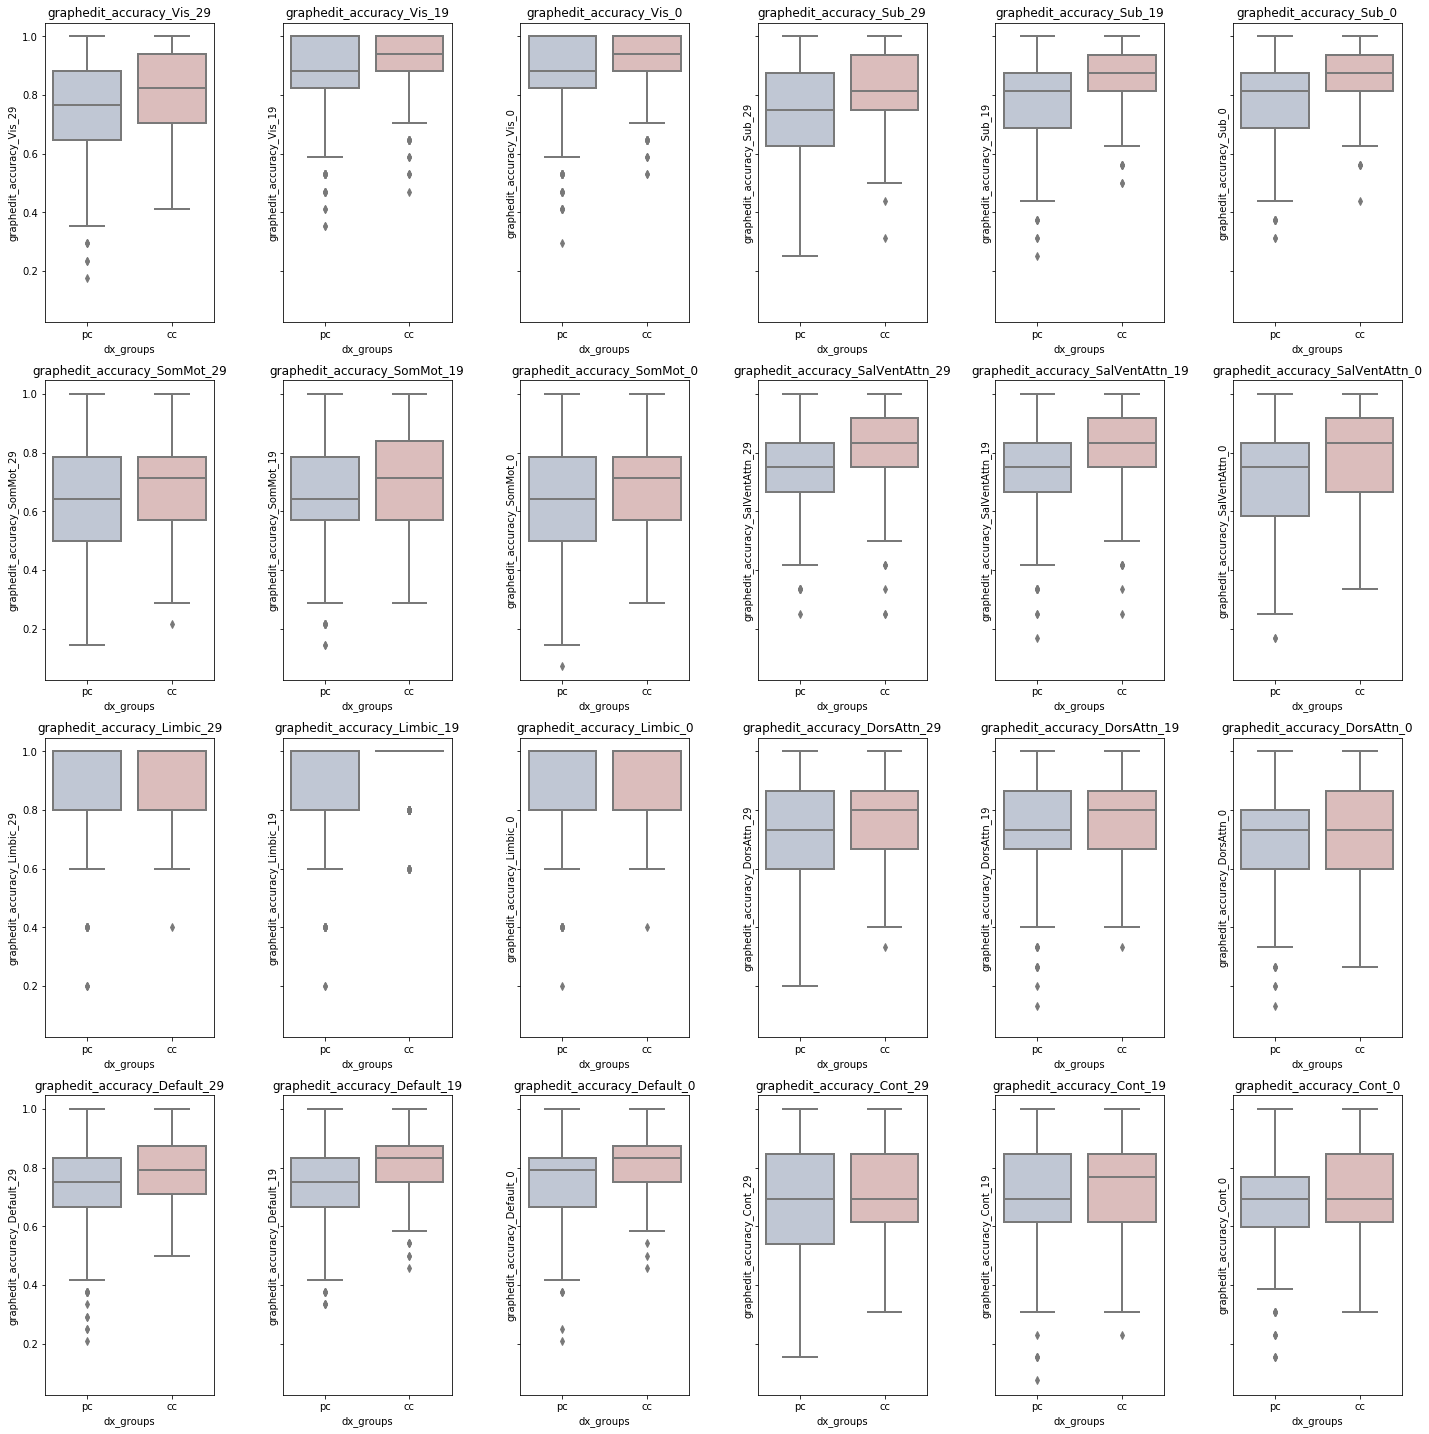

In [130]:
# Box plot
df_dist_sub = df_dist_all[(df_dist_all['times'] == 's1s1')]
accuracy_measures_filter = accuracy_measures_all.copy()
accuracy_measures_filter = [x for x in accuracy_measures_filter if '_Vis_' in x or '_Sub_' in x or '_SomMot_' in x or '_SalVentAttn_' in x or '_Limbic_' in x or '_DorsAttn_' in x or '_Default_' in x or '_Cont_' in x]
accuracy_measures_filter.sort(reverse=True)

fig, ax = plt.subplots(int(np.ceil(len(accuracy_measures_filter)/6)), 6, sharey=True, figsize=(20, 20))

for i in range(len(accuracy_measures_filter)):
    params = dict(data=df_dist_sub, x='dx_groups', y=accuracy_measures_filter[i], order=['pc', 'cc'], ax=ax[int(i/6), i%6])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    ax[int(i/6), i%6].set_title(accuracy_measures_filter[i])

plt.tight_layout(pad=1.0)
plt.show()

### Testing Result

In [56]:
test_list = np.loadtxt(TEST_PATH, dtype=str)
test_label = np.array([x[0] for x in test_list])
test_triplets = get_triplets(test_list, test_label)
data = [test_triplets, conn_dict, df_roi, columns_network]

In [57]:
p_test_LAST, df_dist_test_LAST = posterior(param_list[LAST_ITER], data)

In [58]:
p_test_MID, df_dist_test_MID = posterior(param_list[MID_ITER], data)

In [59]:
p_test_FIRST, df_dist_test_FIRST = posterior(param_list[FIRST_ITER], data)

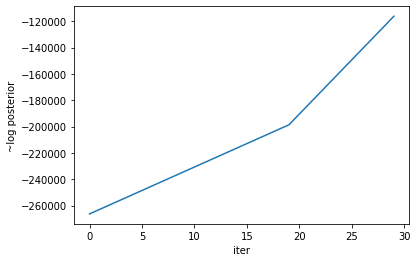

In [60]:
plt.plot([FIRST_ITER, MID_ITER, LAST_ITER], [p_test_FIRST, p_test_MID, p_test_LAST])
plt.xlabel('iter')
plt.ylabel('~log posterior')
plt.show()

In [131]:
df_dist_test_all = df_dist_test_LAST[['subjects', 'dx_groups', 'times']]

df_dist_test_list = [df_dist_test_LAST, df_dist_test_MID, df_dist_test_FIRST]
test_iter_list = [LAST_ITER, MID_ITER, FIRST_ITER]

for idx in range(len(test_iter_list)):
    df_dist_new = df_dist_test_list[idx]
    i = test_iter_list[idx]
    df_dist_new = df_dist_new[['subjects', 'graphedit', 'graphedit_match']]
    df_dist_new['graphedit'] = df_dist_new['graphedit'] / df_dist_new['graphedit'].max()
        
    graphedit_accuracy = [(x == np.arange(len(x))).mean() for x in df_dist_new['graphedit_match']]        
    df_dist_new['graphedit_accuracy_all_'+str(i)] = graphedit_accuracy
    for network in columns_network:
        roi_mask = df_roi['Network'].to_numpy() == network
        graphedit_accuracy = [(x == np.arange(len(x)))[roi_mask].mean() for x in df_dist_new['graphedit_match']]
        df_dist_new['graphedit_accuracy_'+network+'_'+str(i)] = graphedit_accuracy
    for hemisphere in ['R', 'L']:
        roi_mask = df_roi['Hemisphere'].to_numpy() == hemisphere
        graphedit_accuracy = [(x == np.arange(len(x)))[roi_mask].mean() for x in df_dist_new['graphedit_match']]
        df_dist_new['graphedit_accuracy_'+hemisphere+'_'+str(i)] = graphedit_accuracy
    df_dist_new = df_dist_new.rename(columns={'graphedit': 'graphedit_'+str(i), 'graphedit_match': 'graphedit_match_'+str(i)})

    df_dist_test_all = df_dist_test_all.merge(df_dist_new, on='subjects')

In [132]:
dist_dic = {}
for tri in test_triplets:
    (p, c1, c2) = tri
    conn_p, conn_c1, conn_c2 = conn_dict[p]['s1'], conn_dict[c1]['s1'], conn_dict[c2]['s1']
    dist_dic[(p, c1)] = [distance_requester(conn_p, conn_c1).euclidean(),
                         distance_requester(conn_p, conn_c1).pearson()[0]]
    dist_dic[(p, c2)] = [distance_requester(conn_p, conn_c2).euclidean(),
                         distance_requester(conn_p, conn_c2).pearson()[0]]
    if dist_dic.get((c1, c2)) is None:
        dist_dic[(c1, c2)] = [distance_requester(conn_c1, conn_c2).euclidean(),
                              distance_requester(conn_c1, conn_c2).pearson()[0]]
subjects = list(dist_dic.keys())
euclidean = np.array([x[0] for x in dist_dic.values()])
pearson = np.array([x[1] for x in dist_dic.values()])
df_dist_test_all = df_dist_test_all.merge(pd.DataFrame({'subjects': subjects,
                                                        'euclidean': euclidean/euclidean.max(),
                                                        'pearson': pearson/pearson.max()}),
                                          on='subjects')
df_dist_test_all

,subjects,dx_groups,times,graphedit_29,graphedit_match_29,graphedit_accuracy_all_29,graphedit_accuracy_Cont_29,graphedit_accuracy_Default_29,graphedit_accuracy_DorsAttn_29,graphedit_accuracy_Limbic_29,...,graphedit_accuracy_DorsAttn_0,graphedit_accuracy_Limbic_0,graphedit_accuracy_SalVentAttn_0,graphedit_accuracy_SomMot_0,graphedit_accuracy_Sub_0,graphedit_accuracy_Vis_0,graphedit_accuracy_R_0,graphedit_accuracy_L_0,euclidean,pearson
0,"(p048, c024)",pc,s1s1,0.685606,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1.000000,1.000000,1.000000,1.000000,1.0,...,1.000000,1.0,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,0.624913,0.460045
1,"(p048, c025)",pc,s1s1,0.694557,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1.000000,1.000000,1.000000,1.000000,1.0,...,1.000000,1.0,0.916667,1.000000,1.0000,1.000000,0.965517,1.000000,0.651853,0.491866
2,"(c024, c025)",cc,s1s1,0.705181,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.982759,0.846154,1.000000,1.000000,1.0,...,1.000000,1.0,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,0.673097,0.518133
3,"(p048, c012)",pc,s1s1,0.753863,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.982759,1.000000,1.000000,1.000000,1.0,...,1.000000,0.8,1.000000,1.000000,1.0000,0.941176,0.965517,1.000000,0.748214,0.637349
4,"(c024, c012)",cc,s1s1,0.726880,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.982759,1.000000,1.000000,1.000000,1.0,...,0.800000,1.0,1.000000,1.000000,0.9375,1.000000,1.000000,0.931034,0.703461,0.556684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,"(p038, c025)",pc,s1s1,0.960918,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.862069,0.769231,0.958333,0.800000,1.0,...,0.733333,1.0,0.666667,0.857143,0.8125,1.000000,0.896552,0.827586,0.924838,0.863316
65,"(p038, c012)",pc,s1s1,1.000000,"[104, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...",0.793103,0.846154,0.916667,0.733333,0.8,...,0.733333,1.0,0.750000,0.928571,0.7500,1.000000,0.844828,0.896552,1.000000,1.000000
66,"(p038, c034)",pc,s1s1,0.932814,"[104, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 18, 20, 1...",0.810345,0.846154,0.958333,0.666667,1.0,...,0.666667,1.0,0.833333,0.428571,0.8750,1.000000,0.810345,0.862069,0.919190,0.883313
67,"(p038, c007)",pc,s1s1,0.945965,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.879310,0.846154,0.958333,0.733333,1.0,...,0.733333,1.0,0.833333,0.928571,0.8125,1.000000,0.879310,0.913793,0.882412,0.803887


In [133]:
tests = ['mean(pc)', 'mean(cc)',
         'std(pc)', 'std(cc)',
         'Normality_stats(pc)', 'Normality_stats(cc)', 'Normality_p(pc)', 'Normality_p(cc)',
         'levene_stats(pc/cc)', 'levene_p(pc/cc)',
         't-test_stats(pc/cc)', 't-test_p(pc/cc)', 't-test_es(pc/cc)',
         'mannwhitneyu_stats(pc/cc)', 'mannwhitneyu_p(pc/cc)', 'mannwhitneyu_es(pc/cc)']
df_test_test_all = pd.DataFrame({'tests': tests})

for dist_measure in dist_measures_all+accuracy_measures_all:
    g0 = df_dist_test_all[(df_dist_test_all['dx_groups'] == 'pc') & (df_dist_test_all['times'] == 's1s1')][dist_measure]
    g1 = df_dist_test_all[(df_dist_test_all['dx_groups'] == 'cc') & (df_dist_test_all['times'] == 's1s1')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.std(g0), np.std(g1)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    test_score_list = test_score_list + [statistics0, statistics1, p0, p1]
    
    statistics0, p0 = stats.levene(g0, g1)
    test_score_list = test_score_list + [statistics0, p0]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    #if p0 < 0.01:
    #    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    #else:
    #    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=True)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    test_score_list = test_score_list + [statistics0, p0, es0]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    test_score_list = test_score_list + [statistics0, p0, es0]
    
    df_test_test_all[dist_measure] = test_score_list
df_test_test_all = df_test_test_all.set_index('tests')

In [134]:
tests_filter = tests.copy()
dist_measures_filter = dist_measures_all.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test_test_all.loc[tests_filter][dist_measures_filter]

,euclidean,pearson,graphedit_29,graphedit_19,graphedit_0
tests,,,,,
mean(pc),7.606978e-01,0.631815,0.766561,0.795420,0.809522
mean(cc),6.711693e-01,0.529711,0.705033,0.738717,0.754077
std(pc),9.083854e-02,0.121387,0.085282,0.074402,0.070057
std(cc),3.127822e-02,0.038852,0.020916,0.024533,0.025579
Normality_p(pc),8.947703e-02,0.010638,0.001231,0.026396,0.302578
Normality_p(cc),6.111866e-01,0.988959,0.973075,0.385927,0.087866
levene_p(pc/cc),2.738081e-03,0.002289,0.005955,0.006245,0.004158
t-test_p(pc/cc),1.229867e-07,0.000002,0.000012,0.000016,0.000015
t-test_es(pc/cc),1.091175e+00,0.933194,0.804811,0.844850,0.874570


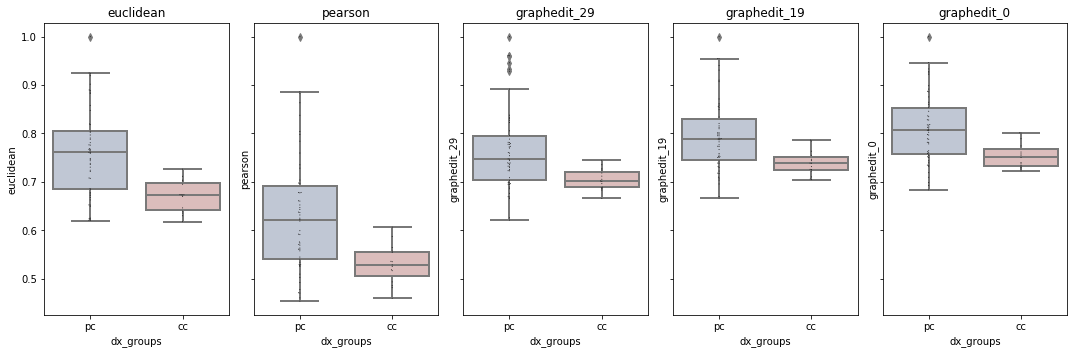

In [135]:
# Box plot
df_dist_sub = df_dist_test_all[(df_dist_test_all['times'] == 's1s1')]
fig, ax = plt.subplots(1, len(dist_measures_filter), sharey=True, figsize=(15, 5))

for i in range(len(dist_measures_filter)):
    params = dict(data=df_dist_sub, x='dx_groups', y=dist_measures_filter[i], order=['pc', 'cc'], ax=ax[i])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    sns.swarmplot(color=".1", size=1, **params)
    ax[i].set_title(dist_measures_filter[i])
    
plt.tight_layout(pad=1.0)
plt.show()

In [136]:
tests_filter = tests.copy()
accuracy_measures_filter = accuracy_measures_all.copy()
accuracy_measures_filter = [x for x in accuracy_measures_filter if '_all_' in x or '_L_' in x or '_R_' in x]
accuracy_measures_filter.sort(reverse=True)
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test_test_all.loc[tests_filter][accuracy_measures_filter]

,graphedit_accuracy_all_29,graphedit_accuracy_all_19,graphedit_accuracy_all_0,graphedit_accuracy_R_29,graphedit_accuracy_R_19,graphedit_accuracy_R_0,graphedit_accuracy_L_29,graphedit_accuracy_L_19,graphedit_accuracy_L_0
tests,,,,,,,,,
mean(pc),9.634419e-01,0.968231,9.667944e-01,9.626437e-01,9.690294e-01,9.677522e-01,9.642401e-01,9.674330e-01,9.658365e-01
mean(cc),9.919540e-01,0.993678,9.862069e-01,9.908046e-01,9.919540e-01,9.885057e-01,9.931034e-01,9.954023e-01,9.839080e-01
std(pc),5.156252e-02,0.034476,4.387582e-02,5.849190e-02,4.778297e-02,4.944381e-02,5.887667e-02,3.719634e-02,4.674770e-02
std(cc),8.601511e-03,0.009159,1.883445e-02,1.524885e-02,1.649736e-02,1.957401e-02,1.379310e-02,1.172188e-02,2.848164e-02
Normality_p(pc),3.824543e-09,0.000002,9.998034e-09,1.633876e-09,8.325141e-10,2.080607e-09,8.906179e-10,1.110924e-06,3.847936e-08
Normality_p(cc),6.561605e-05,0.000103,7.234929e-04,1.138778e-05,6.530295e-06,2.651206e-05,3.480979e-06,7.525482e-07,3.577863e-05
levene_p(pc/cc),5.340407e-02,0.004205,1.861612e-01,7.317643e-02,7.613668e-02,1.215596e-01,6.772938e-02,8.537068e-06,1.647302e-01
t-test_p(pc/cc),3.017392e-04,0.000010,1.662787e-02,2.621309e-03,5.141112e-03,1.865322e-02,1.826611e-03,1.564349e-05,7.787818e-02
t-test_es(pc/cc),-6.194478e-01,-0.822264,-4.857754e-01,-5.365210e-01,-5.311254e-01,-4.624562e-01,-5.472395e-01,-8.345621e-01,-4.147842e-01


In [137]:
tests_filter = tests.copy()
accuracy_measures_filter = accuracy_measures_all.copy()
accuracy_measures_filter = [x for x in accuracy_measures_filter if '_Limbic_' in x or '_DorsAttn_' in x or '_Default_' in x or '_Cont_' in x]
accuracy_measures_filter.sort(reverse=True)
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test_all.loc[tests_filter][accuracy_measures_filter]

,graphedit_accuracy_Limbic_29,graphedit_accuracy_Limbic_19,graphedit_accuracy_Limbic_0,graphedit_accuracy_DorsAttn_29,graphedit_accuracy_DorsAttn_19,graphedit_accuracy_DorsAttn_0,graphedit_accuracy_Default_29,graphedit_accuracy_Default_19,graphedit_accuracy_Default_0,graphedit_accuracy_Cont_29,graphedit_accuracy_Cont_19,graphedit_accuracy_Cont_0
tests,,,,,,,,,,,,
mean(pc),8.786638e-01,8.780172e-01,8.640086e-01,7.242816e-01,7.262213e-01,6.927443e-01,7.311422e-01,7.590248e-01,7.604167e-01,6.856764e-01,6.986903e-01,6.861737e-01
mean(cc),9.369458e-01,9.443350e-01,9.428571e-01,7.683087e-01,7.645320e-01,7.282430e-01,7.849959e-01,8.109606e-01,8.177340e-01,7.163698e-01,7.303903e-01,7.176961e-01
std(pc),1.541717e-01,1.532393e-01,1.564624e-01,1.508420e-01,1.492067e-01,1.533628e-01,1.339157e-01,1.293504e-01,1.269307e-01,1.632000e-01,1.543966e-01,1.548397e-01
std(cc),1.156031e-01,1.057692e-01,1.016403e-01,1.419719e-01,1.358983e-01,1.466515e-01,1.077403e-01,1.065500e-01,1.015811e-01,1.403348e-01,1.454456e-01,1.423199e-01
Normality_p(pc),1.317900e-35,1.792778e-35,6.843557e-34,4.417305e-13,6.680524e-13,1.739130e-11,4.523461e-12,3.236157e-12,1.472837e-12,4.120632e-13,3.327853e-14,6.267316e-13
Normality_p(cc),4.766406e-30,1.022995e-30,3.124562e-30,9.481120e-09,4.417339e-08,3.384021e-07,1.164957e-05,2.676593e-07,1.449536e-07,3.160668e-08,1.259122e-08,1.736973e-08
levene_p(pc/cc),1.387809e-11,4.727184e-15,2.600446e-35,5.130706e-01,1.894132e-01,4.303985e-01,2.111339e-04,1.951587e-04,2.793739e-06,2.906285e-03,3.201076e-01,7.949870e-02
t-test_p(pc/cc),6.212505e-14,3.741513e-19,1.416834e-26,4.071269e-07,5.069597e-06,6.713149e-05,1.998400e-14,5.000557e-14,9.154280e-18,5.072578e-04,3.497816e-04,3.137529e-04
t-test_es(pc/cc),-4.060181e-01,-4.719689e-01,-5.550759e-01,-2.970765e-01,-2.636861e-01,-2.345418e-01,-4.256157e-01,-4.227018e-01,-4.784738e-01,-1.959973e-01,-2.089224e-01,-2.085601e-01


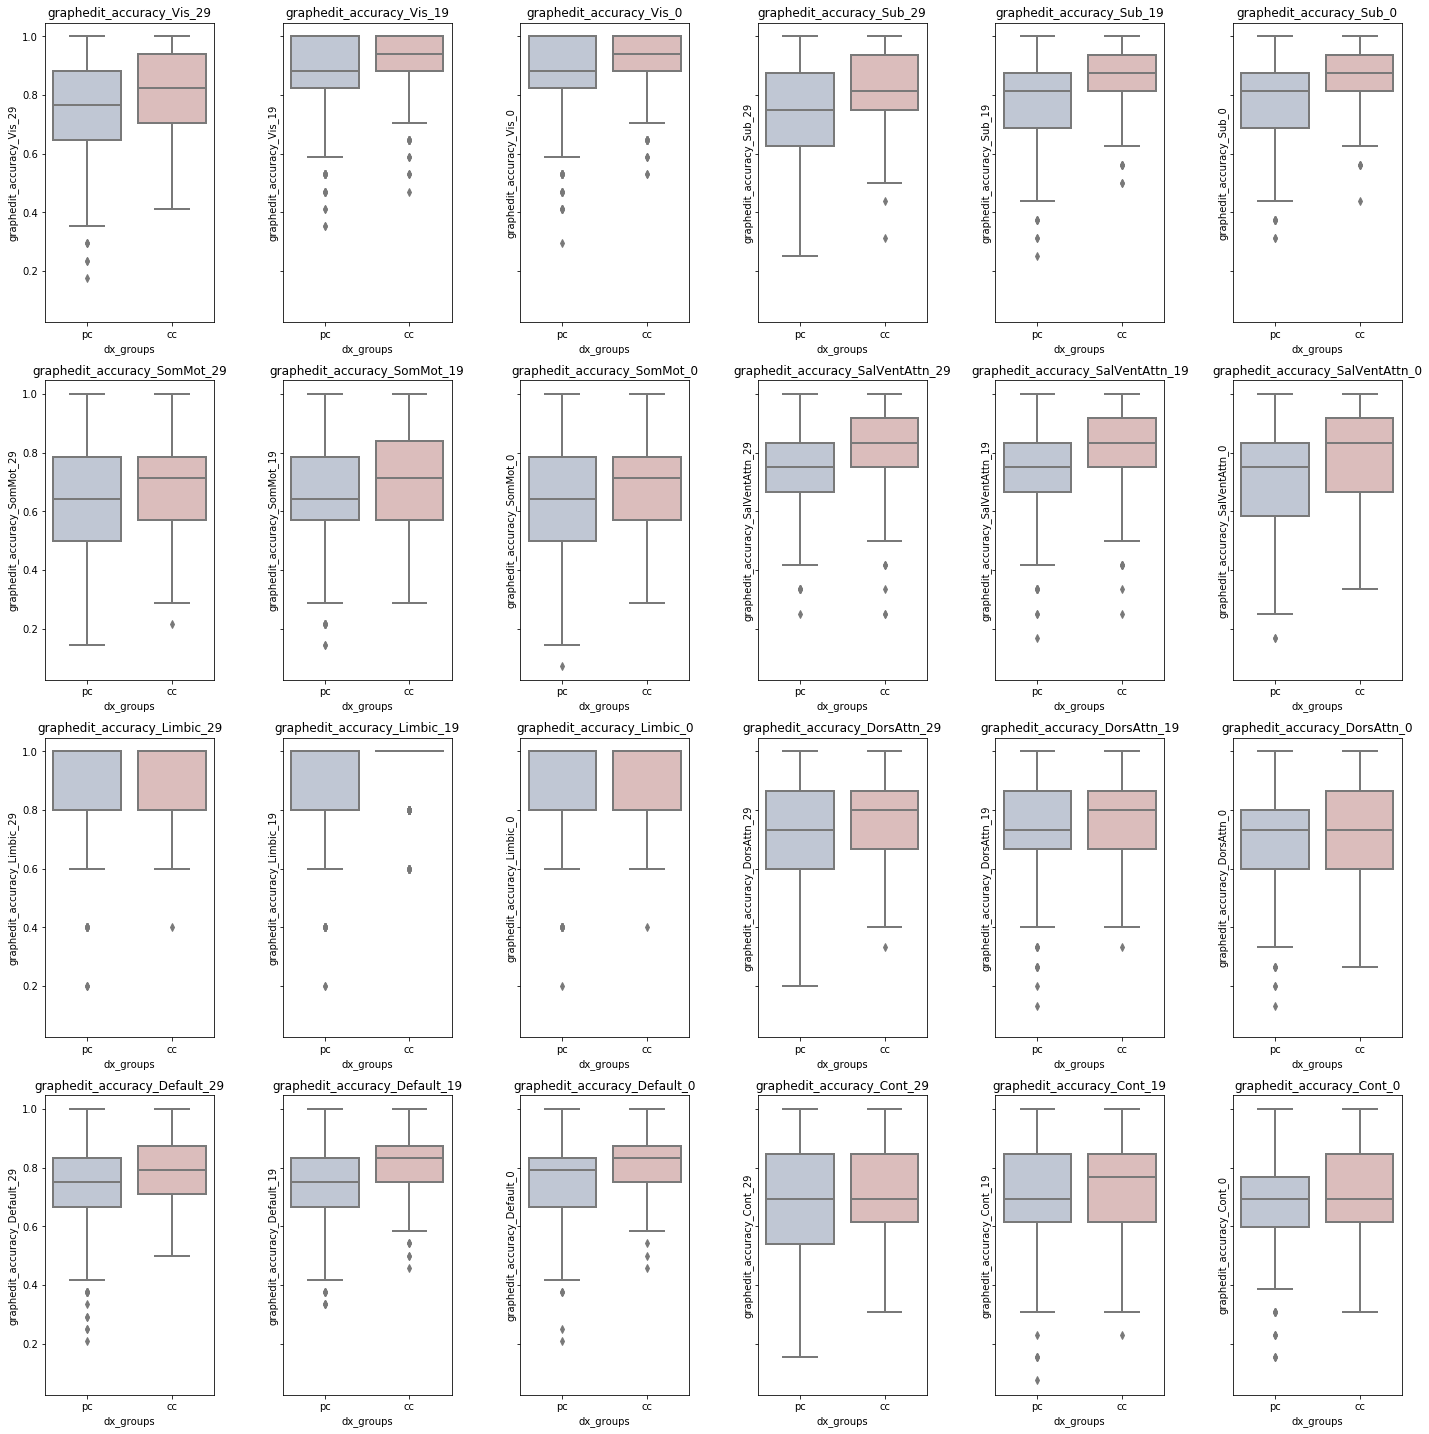

In [139]:
# Box plot
df_dist_sub = df_dist_all[(df_dist_all['times'] == 's1s1')]
accuracy_measures_filter = accuracy_measures_all.copy()
accuracy_measures_filter = [x for x in accuracy_measures_filter if '_Vis_' in x or '_Sub_' in x or '_SomMot_' in x or '_SalVentAttn_' in x or '_Limbic_' in x or '_DorsAttn_' in x or '_Default_' in x or '_Cont_' in x]
accuracy_measures_filter.sort(reverse=True)

fig, ax = plt.subplots(int(np.ceil(len(accuracy_measures_filter)/6)), 6, sharey=True, figsize=(20, 20))

for i in range(len(accuracy_measures_filter)):
    params = dict(data=df_dist_sub, x='dx_groups', y=accuracy_measures_filter[i], order=['pc', 'cc'], ax=ax[int(i/6), i%6])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    ax[int(i/6), i%6].set_title(accuracy_measures_filter[i])

plt.tight_layout(pad=1.0)
plt.show()

### Node factors

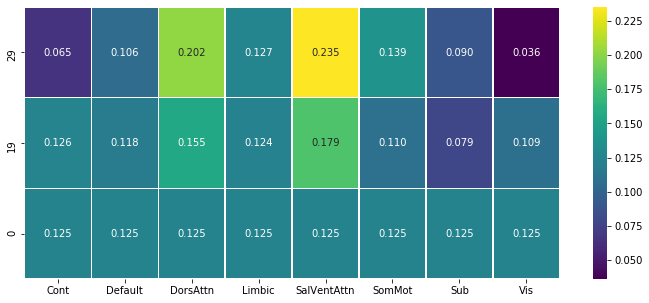

In [140]:
fig, ax = plt.subplots(figsize=(12, 5))
factors = np.array(param_list)[iter_list]
sns.heatmap(factors/factors.sum(axis=1, keepdims=True), annot=True, fmt=".3f", linewidths=.2,
            xticklabels=columns_network, yticklabels=iter_list,
            cmap="viridis", ax=ax)
plt.show()